# Hybrid Financial Intelligence System
## Capstone Project Report Notebook (High-Volatility Regime)

**Author:** Hassen  
**Date:** February 2026  
**Scope:** Predict 5-day upside moves for high-beta equities and convert probabilities into risk-aware decisions.


## Capstone Project Outline (Professor Requirements)

### I. Introduction
- Overview of the capstone project and its objectives
- Clear statement of the problem being addressed
- Motivation for the project and its practical significance

### II. Problem Definition
- Detailed description of the problem
- Assumptions and constraints
- Expected outcomes or success criteria

### III. Data Collection and Preprocessing
- Description of the dataset(s) used, data sources and collection methods
- Data quality issues and handling of missing or inconsistent values
- Data preprocessing steps such as cleaning, normalization, encoding, or feature selection

### IV. Exploratory Data Analysis (EDA)
- Summary statistics and key characteristics of the data
- Visualizations illustrating trends, distributions, and relationships
- Insights discovered during EDA and their impact on model selection

### V. Methodology
- Overview of the machine learning or analytical approach
- Description of models or algorithms used and justification for model choices
- Feature engineering and data transformation techniques

### VI. Implementation
- System architecture or workflow overview
- Key implementation details and code structure as well as libraries used
- Reproducibility considerations (environment setup, versions, seeds)

### VII. Training and Evaluation
- Data splitting strategy (training, validation, testing), evaluation metrics & validation techniques
- Comparison of model performance
- Challenges and limitations encountered

### VIII. Results and Discussion
- Final model performance results and interpretation of results in relation to the problem
- Strengths and weaknesses of the solution
- Practical implications of the findings

### IX. Conclusion
- Summary of key achievements
- Lessons learned during the project
- Overall impact and value of the solution

### X. Future Work
- Possible improvements to the current approach
- Additional features, data sources, or models to explore
- Opportunities for real-world deployment or scaling

### XII. Appendices
- Additional figures or tables
- Detailed code snippets or pseudocode
- Configuration files or setup instructions


## I. Introduction

I build a hybrid financial intelligence workflow that predicts whether a high-volatility stock exceeds a **3.5% forward return** over the next **5 trading days**.

I pursue three objectives:
1. Produce reliable probability forecasts under volatility-heavy conditions.
2. Convert forecasts into trading decisions with explicit risk trade-offs.
3. Document an iterative process where data evidence drives model changes.

This project matters because high-beta stocks generate large price moves and large false signals. A disciplined ML pipeline can improve decision quality only if I validate it with chronological testing and realistic strategy rules.


## II. Problem Definition

### Problem Statement
I solve a supervised binary classification problem:

\[
	ext{target}_t = \mathbb{1}(r_{t,t+5} > 0.035)
\]

where \(r_{t,t+5}\) is the 5-day forward return.

### Assumptions and Constraints
- I preserve chronological order to prevent leakage.
- I evaluate strategy returns on **non-overlapping 5-day windows** to avoid inflated compounding.
- I use a long/cash signal policy for safety in volatile markets.
- I treat transaction costs and slippage as out-of-scope for the base version (addressed in Future Work).

### Success Criteria
- High precision on predicted positive class.
- Stable holdout behavior (2023+ period).
- Threshold choice justified by both ML metrics and strategy metrics (Sharpe, drawdown, coverage).


In [2]:
from pathlib import Path
import sys
import warnings
warnings.filterwarnings("ignore")

# Resolve project root robustly (works from repo root or notebooks/)
cwd = Path.cwd().resolve()
project_root = None
for p in [cwd, *cwd.parents]:
    if (p / "src").exists() and (p / "data").exists():
        project_root = p
        break

if project_root is None:
    raise RuntimeError("Could not find project root containing src/ and data/.")

src_path = project_root / "src"
data_dir = project_root / "data"

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("Project root:", project_root)
print("Source path :", src_path)
print("Data path   :", data_dir)


Project root: /Users/hassen/Documents/GitHub/data_science
Source path : /Users/hassen/Documents/GitHub/data_science/src
Data path   : /Users/hassen/Documents/GitHub/data_science/data


In [3]:
pip install python-dotenv



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data_ingestion import merge_price_and_macro
from features import add_technical_indicators, build_rolling_window_dataset
from model import ModelConfig, train_xgboost_time_series, evaluate_on_holdout
from backtest import annualized_return, max_drawdown, sharpe_ratio

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from xgboost import XGBClassifier

SEED = 42
np.random.seed(SEED)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

C_BUY = "#1f9d55"
C_RISK = "#cf222e"
C_MAIN = "#1f6feb"
C_NEUTRAL = "#6e7781"


## III. Data Collection and Preprocessing

### 3.1 Dataset Description, Sources, and Collection
I use the following project artifacts:
- `prices_daily.csv`: OHLCV data downloaded via `yfinance` pipeline.
- `macro_10y_yield.csv`: macro factor (10Y treasury yield) from FRED ingestion flow.
- `news_headlines.csv`: optional news context collected through API ingestion.

The modeling table is rebuilt in this notebook to prove reproducibility.


In [5]:
prices = pd.read_csv(data_dir / "prices_daily.csv", parse_dates=["date"])
macro = pd.read_csv(data_dir / "macro_10y_yield.csv", parse_dates=["date"])
news_path = data_dir / "news_headlines.csv"
news = pd.read_csv(news_path, parse_dates=["date"]) if news_path.exists() else pd.DataFrame()

source_summary = pd.DataFrame([
    {
        "dataset": "prices_daily.csv",
        "rows": len(prices),
        "columns": prices.shape[1],
        "start_date": prices["date"].min().date(),
        "end_date": prices["date"].max().date(),
    },
    {
        "dataset": "macro_10y_yield.csv",
        "rows": len(macro),
        "columns": macro.shape[1],
        "start_date": macro["date"].min().date(),
        "end_date": macro["date"].max().date(),
    },
    {
        "dataset": "news_headlines.csv" if not news.empty else "news_headlines.csv (missing)",
        "rows": 0 if news.empty else len(news),
        "columns": 0 if news.empty else news.shape[1],
        "start_date": None if news.empty else news["date"].min().date(),
        "end_date": None if news.empty else news["date"].max().date(),
    },
])

print("Tickers:", sorted(prices["ticker"].unique().tolist()))
source_summary


Tickers: ['CRSP', 'PLTR', 'SMCI']


,dataset,rows,columns,start_date,end_date
0,prices_daily.csv,4414,8,2020-01-02,2026-02-09
1,macro_10y_yield.csv,5026,2,2006-01-03,2026-02-04
2,news_headlines.csv,111,3,2026-02-02,2026-02-06


### Critical Thinking Checkpoint (Data Sources)
I verify that sources cover the same economic period and that ticker coverage matches the regime design.

After running the previous cell, I explicitly confirm:
- The time horizon is long enough to include multiple volatility environments.
- The ticker list aligns with the high-volatility objective.
- Missing optional sentiment does not break the core pipeline.


### 3.2 Data Quality Issues and Handling
I check for duplicates, missing values, inconsistent ordering, and structural anomalies before feature engineering. I treat data quality failures as hard blockers.


In [6]:
def data_quality_report(df, name, date_col="date", key_cols=None):
    report = {
        "dataset": name,
        "rows": len(df),
        "duplicates": int(df.duplicated().sum()),
        "missing_cells": int(df.isna().sum().sum()),
        "date_nulls": int(df[date_col].isna().sum()) if date_col in df.columns else np.nan,
    }
    if key_cols:
        key_cols = [c for c in key_cols if c in df.columns]
        report["duplicate_keys"] = int(df.duplicated(subset=key_cols).sum()) if key_cols else np.nan
    else:
        report["duplicate_keys"] = np.nan
    return report

reports = [
    data_quality_report(prices, "prices", key_cols=["ticker", "date"]),
    data_quality_report(macro, "macro", key_cols=["date"]),
]
if not news.empty:
    reports.append(data_quality_report(news, "news", key_cols=["ticker", "date", "headline"]))

dq_report = pd.DataFrame(reports)

# Per-ticker ordering check for prices
order_check = (
    prices.sort_values(["ticker", "date"]).groupby("ticker")["date"].apply(lambda s: bool(s.is_monotonic_increasing))
)

print("Per-ticker date monotonicity:")
print(order_check.to_string())
print("\nData quality report:")
dq_report


Per-ticker date monotonicity:
ticker
CRSP    True
PLTR    True
SMCI    True

Data quality report:


,dataset,rows,duplicates,missing_cells,date_nulls,duplicate_keys
0,prices,4414,0,0,0,0
1,macro,5026,0,0,0,0
2,news,111,0,0,0,0


### Critical Thinking Checkpoint (Data Quality)
I do not continue model development until this report shows acceptable quality.

If duplicates or missingness appear, I document:
1. Root cause (source/API/merge artifact).
2. Fix strategy (drop, impute, or recollect).
3. Impact on downstream feature validity.


### 3.3 Preprocessing and Feature Construction
I apply these transformations:
- Merge macro to daily price rows with forward-fill alignment.
- Engineer technical features (RSI, MACD, Bollinger, MA, volume z-score, ATR).
- Construct rolling-window features and generate target labels.
- Preserve temporal order for valid train/test splitting.


In [9]:
merged = merge_price_and_macro(prices, macro)
featured = add_technical_indicators(merged)
print(featured.info())
dataset = build_rolling_window_dataset(featured, window_days=14, horizon_days=5, threshold=0.035)
print(dataset.head().info())
dataset = dataset.sort_values("date").reset_index(drop=True)

print("Merged shape   :", merged.shape)
print("Featured shape :", featured.shape)
print("Dataset shape  :", dataset.shape)
print("Dataset columns:", len(dataset.columns))
print(dataset.head().info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4414 entries, 0 to 4413
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            4414 non-null   datetime64[ns]
 1   open            4414 non-null   float64       
 2   high            4414 non-null   float64       
 3   low             4414 non-null   float64       
 4   close           4414 non-null   float64       
 5   adj_close       4414 non-null   float64       
 6   volume          4414 non-null   int64         
 7   ticker          4414 non-null   object        
 8   ten_year_yield  4414 non-null   float64       
 9   rsi_14          4375 non-null   float64       
 10  macd            4339 non-null   float64       
 11  macd_signal     4315 non-null   float64       
 12  macd_hist       4315 non-null   float64       
 13  bb_high         4357 non-null   float64       
 14  bb_low          4357 non-null   float64       
 15  bb_w

In [10]:
target_dist = dataset["target"].value_counts(normalize=True).rename("ratio").sort_index()
feature_count = len(dataset.columns) - 4  # ticker, date, target, future_return

prep_summary = pd.DataFrame([
    {"item": "modeling_rows", "value": len(dataset)},
    {"item": "tickers", "value": dataset["ticker"].nunique()},
    {"item": "feature_columns", "value": feature_count},
    {"item": "positive_class_ratio", "value": round(float(target_dist.get(1, np.nan)), 4)},
])

prep_summary


,item,value
0,modeling_rows,4357.0000
1,tickers,3.0000
2,feature_columns,42.0000
3,positive_class_ratio,0.3427


### Critical Thinking Checkpoint (Preprocessing)
I use this section to confirm whether class imbalance and feature dimensionality support my modeling plan.

Decision logic:
- If positive class is very rare, I prioritize precision and class balancing.
- If feature count grows quickly, I validate value through ablation instead of assuming more is better.


## IV. Exploratory Data Analysis (EDA)

I use EDA to answer concrete modeling questions, not to produce visuals only.

Questions:
1. How strong is the volatility regime by ticker?
2. How difficult is the target threshold relative to return distribution?
3. Which feature families show directional relationship with target?
4. How should these findings influence model choice and threshold policy?


### 4.1 Summary Statistics and Key Characteristics


In [11]:
price_stats = prices.groupby("ticker").agg(
    obs=("adj_close", "size"),
    close_mean=("adj_close", "mean"),
    close_std=("adj_close", "std"),
    close_min=("adj_close", "min"),
    close_max=("adj_close", "max"),
    volume_mean=("volume", "mean"),
)

# Realized volatility proxy from daily returns
tmp = prices.sort_values(["ticker", "date"]).copy()
tmp["ret_1d"] = tmp.groupby("ticker")["adj_close"].pct_change()
vol_stats = tmp.groupby("ticker")["ret_1d"].agg(daily_vol="std", mean_ret="mean")
summary_stats = price_stats.join(vol_stats)

summary_stats


,obs,close_mean,close_std,close_min,close_max,volume_mean,daily_vol,mean_ret
ticker,,,,,,,,
CRSP,1534,70.094905,30.725691,31.270,210.039993,1.624263e+06,0.038873,0.000631
PLTR,1346,44.743548,52.874847,6.000,207.179993,5.925820e+07,0.044540,0.002983
SMCI,1534,23.025966,25.297634,1.598,118.806999,2.773003e+07,0.049258,0.002927


### Critical Thinking Checkpoint (Summary Stats)
I interpret volatility and return dispersion before selecting model behavior.

I explicitly ask:
- Do these tickers justify a higher success threshold than stable large-caps?
- Which ticker appears most unstable, and does that affect portfolio-level risk control?


### 4.2 Visualizations: Trends, Distributions, and Relationships


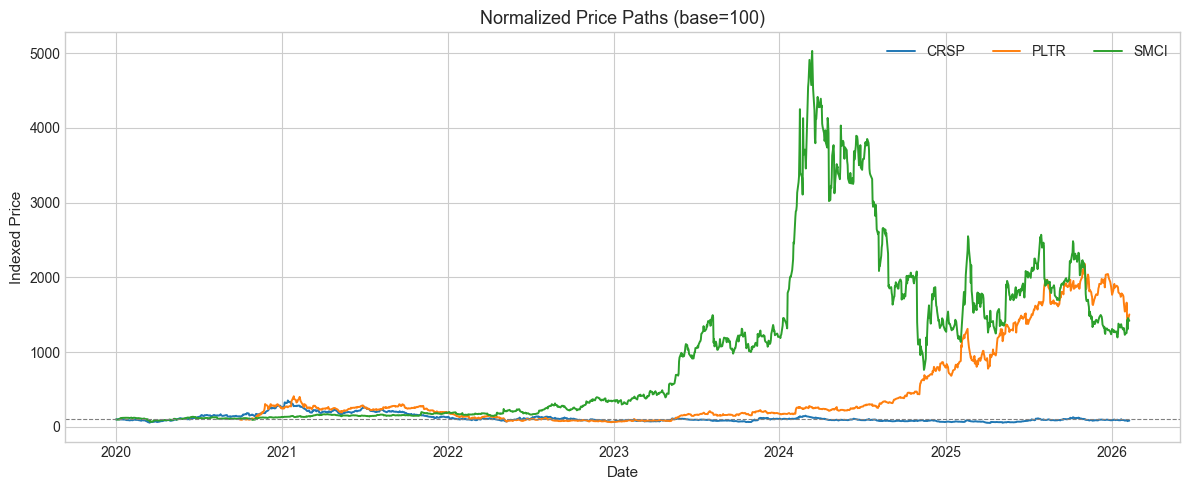

In [12]:
# Normalized price trend comparison
fig, ax = plt.subplots()
for ticker, g in prices.sort_values('date').groupby('ticker'):
    idx = g['adj_close'] / g['adj_close'].iloc[0] * 100
    ax.plot(g['date'], idx, linewidth=1.4, label=ticker)
ax.axhline(100, ls='--', lw=0.8, c='gray')
ax.set_title('Normalized Price Paths (base=100)')
ax.set_xlabel('Date')
ax.set_ylabel('Indexed Price')
ax.legend(ncol=3)
plt.tight_layout()
plt.show()


**Interpretation Prompt:** I compare trend persistence and drawdown behavior across tickers and connect these patterns to model instability risk.


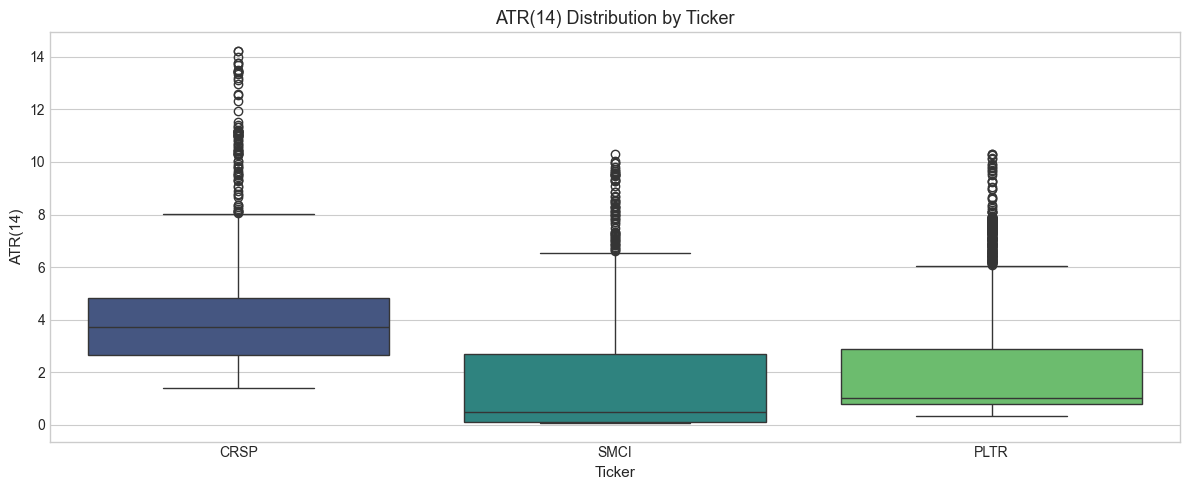

In [12]:
# ATR profile by ticker
if 'atr_14_last' in dataset.columns:
    fig, ax = plt.subplots()
    sns.boxplot(data=dataset, x='ticker', y='atr_14_last', palette='viridis', ax=ax)
    ax.set_title('ATR(14) Distribution by Ticker')
    ax.set_xlabel('Ticker')
    ax.set_ylabel('ATR(14)')
    plt.tight_layout()
    plt.show()


**Interpretation Prompt:** I use ATR spread to justify volatility-aware features and ATR-based risk controls.


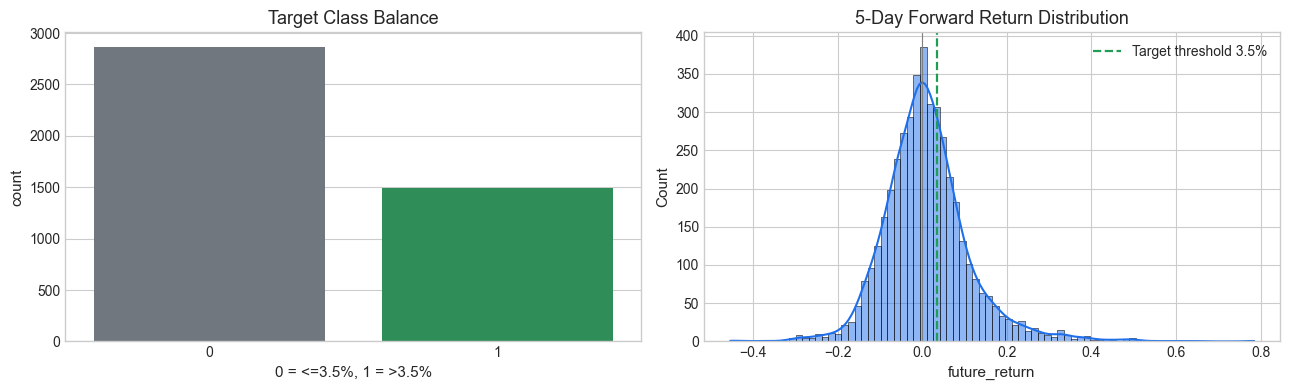

In [13]:
# Target and forward-return difficulty
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

sns.countplot(data=dataset, x='target', palette=[C_NEUTRAL, C_BUY], ax=axes[0])
axes[0].set_title('Target Class Balance')
axes[0].set_xlabel('0 = <=3.5%, 1 = >3.5%')

sns.histplot(dataset['future_return'], bins=80, kde=True, color=C_MAIN, ax=axes[1])
axes[1].axvline(0.035, ls='--', lw=1.6, c=C_BUY, label='Target threshold 3.5%')
axes[1].axvline(0.0, ls='-', lw=0.8, c='gray')
axes[1].set_title('5-Day Forward Return Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()


**Interpretation Prompt:** I evaluate how often the threshold captures meaningful moves versus rare tail events and adjust expectations for recall accordingly.


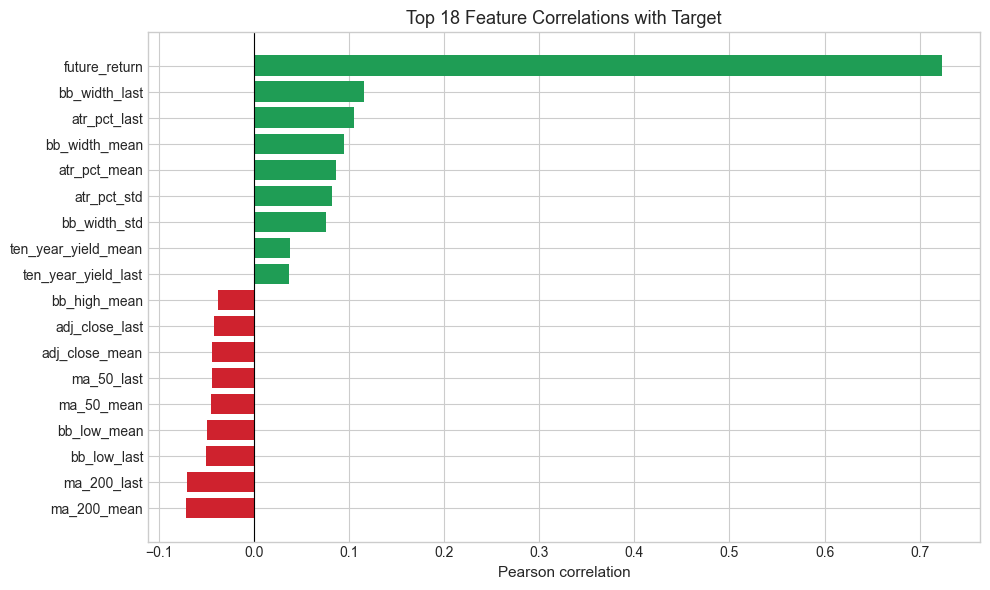

In [14]:
# Top linear relationships with target
num_cols = [c for c in dataset.columns if c not in ('ticker', 'date')]
corr = dataset[num_cols].corr()['target'].drop('target').dropna()

top = corr.abs().sort_values(ascending=False).head(18)
plot_vals = corr[top.index].sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
colors = [C_BUY if v > 0 else C_RISK for v in plot_vals.values]
ax.barh(plot_vals.index, plot_vals.values, color=colors)
ax.axvline(0, c='black', lw=0.8)
ax.set_title('Top 18 Feature Correlations with Target')
ax.set_xlabel('Pearson correlation')
plt.tight_layout()
plt.show()


### 4.3 EDA Insights and Impact on Model Selection
I convert observations into modeling choices:
- I retain ATR-derived features because volatility structure is central to this regime.
- I emphasize precision-sensitive evaluation because class imbalance and threshold difficulty reduce recall naturally.
- I plan threshold tuning and feature ablation because EDA suggests trade-offs, not one obvious fixed setting.


## V. Methodology

### 5.1 ML Approach Overview
I use supervised binary classification with tabular engineered features.

### 5.2 Model Candidates and Justification
I compare three families:
- Logistic Regression: strong linear baseline.
- Random Forest: nonlinear, robust baseline with bagging.
- XGBoost: gradient boosting model expected to capture nonlinear interactions best.

### 5.3 Feature Engineering and Transformations
I use rolling statistics (mean/std/last) over a 14-day lookback for technical, macro, and optional sentiment variables.


## VI. Implementation

### 6.1 Workflow Architecture
```mermaid
flowchart TD
A[Load Raw Data] --> B[Data Quality Checks]
B --> C[Merge Price + Macro]
C --> D[Technical Indicators + ATR]
D --> E[Rolling Feature Dataset]
E --> F[Chronological Split]
F --> G[Train Models]
G --> H[Evaluate + Compare]
H --> I[Threshold Optimization]
I --> J[Ablation + Final Decision]
```

### 6.2 Key Implementation Notes
I keep reusable logic inside the notebook for transparency and grading clarity.

### 6.3 Reproducibility
I set fixed seeds, explicit cutoff dates, and explicit feature/target definitions.


In [15]:
# helper functions for iterative experimentation

def split_xy(df, target_col='target', drop_cols=('ticker', 'date', 'future_return')):
    if target_col not in df.columns:
        raise KeyError(f"Missing target column: {target_col}")
    y = df[target_col].astype(int).copy()
    drop_set = {target_col, *drop_cols}
    X = df[[c for c in df.columns if c not in drop_set]].copy()
    return X, y


def evaluate_binary_predictions(y_true, y_proba, threshold=0.50):
    y_true = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba).astype(float)
    y_pred = (y_proba >= threshold).astype(int)

    out = {
        'threshold': float(threshold),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
        'coverage': float((y_pred == 1).mean()),
    }
    try:
        out['roc_auc'] = float(roc_auc_score(y_true, y_proba))
    except Exception:
        out['roc_auc'] = np.nan
    try:
        out['pr_auc'] = float(average_precision_score(y_true, y_proba))
    except Exception:
        out['pr_auc'] = np.nan
    return out


def threshold_sweep(y_true, y_proba, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.25, 0.81, 0.05)
    rows = [evaluate_binary_predictions(y_true, y_proba, t) for t in thresholds]
    return pd.DataFrame(rows).sort_values('threshold').reset_index(drop=True)


def train_standard_models(X_train, y_train, random_state=42):
    models = {}

    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=4000, class_weight='balanced', random_state=random_state),
    )
    lr.fit(X_train, y_train)
    models['LogisticRegression'] = lr

    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=8,
        min_samples_leaf=8,
        class_weight='balanced_subsample',
        random_state=random_state,
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)
    models['RandomForest'] = rf

    n_pos = int(y_train.sum())
    n_neg = int(len(y_train) - n_pos)
    spw = (n_neg / n_pos) if n_pos > 0 else 1.0

    xgb = XGBClassifier(
        n_estimators=350,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=spw,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=random_state,
        n_jobs=-1,
    )
    xgb.fit(X_train.values, y_train.values)
    models['XGBoost'] = xgb

    return models


def compare_models(models, X_test, y_test, threshold=0.50):
    rows = []
    for name, model in models.items():
        if isinstance(model, XGBClassifier):
            y_proba = model.predict_proba(X_test.values)[:, 1]
        else:
            y_proba = model.predict_proba(X_test)[:, 1]
        rows.append({'model': name, **evaluate_binary_predictions(y_test, y_proba, threshold)})
    return pd.DataFrame(rows).sort_values(['precision', 'f1', 'recall'], ascending=False).reset_index(drop=True)


def infer_feature_groups(columns):
    return {
        'volatility_atr': [c for c in columns if 'atr_' in c],
        'macro_rates': [c for c in columns if 'ten_year_yield' in c],
        'sentiment': [c for c in columns if c.startswith('sent_') or 'sentiment_momentum' in c],
        'trend_momentum': [c for c in columns if any(k in c for k in ('rsi_', 'macd', 'bb_', 'ma_', 'volume_z'))],
    }


def run_xgboost_ablation(X_train, y_train, X_test, y_test, threshold=0.50, random_state=42):
    groups = infer_feature_groups(list(X_train.columns))
    runs = {'full_model': []}
    for gname, gcols in groups.items():
        runs[f'drop_{gname}'] = list(gcols)

    rows = []
    for run_name, drop_cols in runs.items():
        keep_cols = [c for c in X_train.columns if c not in set(drop_cols)]

        n_pos = int(y_train.sum())
        n_neg = int(len(y_train) - n_pos)
        spw = (n_neg / n_pos) if n_pos > 0 else 1.0

        model = XGBClassifier(
            n_estimators=350,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            scale_pos_weight=spw,
            objective='binary:logistic',
            eval_metric='logloss',
            random_state=random_state,
            n_jobs=-1,
        )
        model.fit(X_train[keep_cols].values, y_train.values)
        y_proba = model.predict_proba(X_test[keep_cols].values)[:, 1]
        rows.append({'experiment': run_name, 'n_features': len(keep_cols), **evaluate_binary_predictions(y_test, y_proba, threshold)})

    return pd.DataFrame(rows).sort_values('precision', ascending=False).reset_index(drop=True)


## VII. Training and Evaluation

### 7.1 Split Strategy, Validation Technique, and Metrics
I split chronologically at `2023-01-01`.
- Train: dates before cutoff.
- Test: dates on/after cutoff.

Validation:
- Time-series cross-validation for baseline model selection.

Primary metrics:
- Precision, recall, F1, ROC-AUC, PR-AUC, coverage.
- Strategy metrics: annualized return, Sharpe ratio, max drawdown.


In [16]:
cutoff = pd.Timestamp('2023-01-01')
train_df = dataset[dataset['date'] < cutoff].copy()
test_df = dataset[dataset['date'] >= cutoff].copy()

X_train_full = train_df.drop(columns=['target'])
y_train = train_df['target'].astype(int)
X_test_full = test_df.drop(columns=['target'])
y_test = test_df['target'].astype(int)

split_summary = pd.DataFrame([
    {'split': 'train', 'rows': len(train_df), 'positive_rate': float(y_train.mean()), 'start': train_df['date'].min(), 'end': train_df['date'].max()},
    {'split': 'test', 'rows': len(test_df), 'positive_rate': float(y_test.mean()), 'start': test_df['date'].min(), 'end': test_df['date'].max()},
])
split_summary


,split,rows,positive_rate,start,end
0,train,2038,0.317959,2020-01-23,2022-12-30
1,test,2319,0.364381,2023-01-03,2026-02-02


In [17]:
# Baseline model with module-defined time-series training routine
config = ModelConfig(window_days=14, horizon_days=5, threshold=0.035)
baseline_model, cv_metrics = train_xgboost_time_series(X_train_full, y_train, config)
baseline_test = evaluate_on_holdout(baseline_model, X_train_full, y_train, X_test_full, y_test)

base_proba = baseline_test['test_proba']
base_eval = evaluate_binary_predictions(y_test, base_proba, threshold=0.50)

baseline_summary = pd.DataFrame([
    {'metric': 'cv_best_precision', 'value': float(cv_metrics['cv_best_precision'])},
    {'metric': 'holdout_precision_at_0.50', 'value': float(base_eval['precision'])},
    {'metric': 'holdout_recall_at_0.50', 'value': float(base_eval['recall'])},
    {'metric': 'holdout_f1_at_0.50', 'value': float(base_eval['f1'])},
    {'metric': 'holdout_roc_auc', 'value': float(base_eval['roc_auc'])},
    {'metric': 'holdout_pr_auc', 'value': float(base_eval['pr_auc'])},
    {'metric': 'signal_coverage', 'value': float(base_eval['coverage'])},
])

baseline_summary


[Model] Fold 1/5 – training...
[Model] Fold 1/5 – evaluating...
[Model] Fold 1/5 precision: 0.4328
[Model] Fold 2/5 – training...
[Model] Fold 2/5 – evaluating...
[Model] Fold 2/5 precision: 0.3810
[Model] Fold 3/5 – training...
[Model] Fold 3/5 – evaluating...
[Model] Fold 3/5 precision: 0.0843
[Model] Fold 4/5 – training...
[Model] Fold 4/5 – evaluating...
[Model] Fold 4/5 precision: 1.0000
[Model] Fold 5/5 – training...
[Model] Fold 5/5 – evaluating...
[Model] Fold 5/5 precision: 0.3261


,metric,value
0,cv_best_precision,1.000000
1,holdout_precision_at_0.50,0.372146
2,holdout_recall_at_0.50,0.385799
3,holdout_f1_at_0.50,0.378850
4,holdout_roc_auc,0.511146
5,holdout_pr_auc,0.362555
6,signal_coverage,0.377749


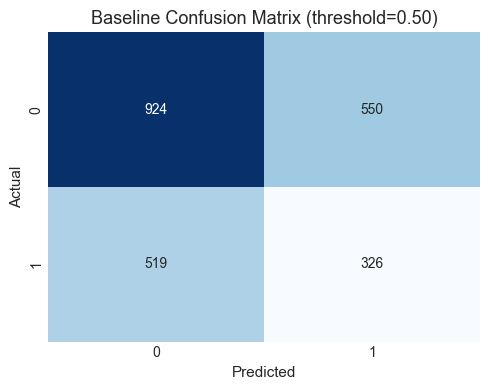

              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1474
           1       0.37      0.39      0.38       845

    accuracy                           0.54      2319
   macro avg       0.51      0.51      0.51      2319
weighted avg       0.54      0.54      0.54      2319



In [18]:
# Confusion matrix for baseline threshold=0.50
base_pred = (base_proba >= 0.50).astype(int)
cm = confusion_matrix(y_test, base_pred)

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
ax.set_title('Baseline Confusion Matrix (threshold=0.50)')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

print(classification_report(y_test, base_pred, zero_division=0))


### 7.2 Comparison of Model Performance (Iteration 1)
I compare model families under the same split and decision threshold.


In [19]:
X_train, y_train_cmp = split_xy(train_df)
X_test, y_test_cmp = split_xy(test_df)

models = train_standard_models(X_train, y_train_cmp, random_state=SEED)
model_cmp = compare_models(models, X_test, y_test_cmp, threshold=0.50)
model_cmp


,model,threshold,precision,recall,f1,coverage,roc_auc,pr_auc
0,RandomForest,0.5,0.393526,0.273373,0.322626,0.253126,0.538786,0.390903
1,LogisticRegression,0.5,0.393103,0.472189,0.429032,0.437689,0.536137,0.390138
2,XGBoost,0.5,0.362998,0.366864,0.364921,0.368262,0.510225,0.363384


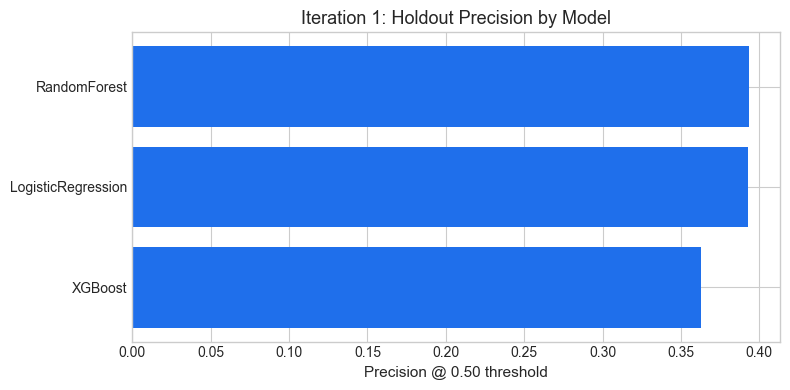

In [20]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_df = model_cmp.sort_values('precision', ascending=True)
ax.barh(plot_df['model'], plot_df['precision'], color=C_MAIN)
ax.set_title('Iteration 1: Holdout Precision by Model')
ax.set_xlabel('Precision @ 0.50 threshold')
plt.tight_layout()
plt.show()


### 7.3 Threshold Tuning (Iteration 2)
I tune the decision threshold because model quality alone does not define trading quality.


In [21]:
sweep = threshold_sweep(y_test, base_proba, thresholds=np.arange(0.30, 0.86, 0.05))
sweep


,threshold,precision,recall,f1,coverage,roc_auc,pr_auc
0,0.30,0.370551,0.628402,0.466198,0.617939,0.511146,0.362555
1,0.35,0.368917,0.556213,0.443605,0.549375,0.511146,0.362555
2,0.40,0.373693,0.507692,0.430507,0.495041,0.511146,0.362555
3,0.45,0.368787,0.439053,0.400864,0.433808,0.511146,0.362555
4,0.50,0.372146,0.385799,0.378850,0.377749,0.511146,0.362555
5,0.55,0.378768,0.342012,0.359453,0.329021,0.511146,0.362555
6,0.60,0.375573,0.291124,0.328000,0.282449,0.511146,0.362555
7,0.65,0.384758,0.244970,0.299349,0.231997,0.511146,0.362555
8,0.70,0.371981,0.182249,0.244639,0.178525,0.511146,0.362555
9,0.75,0.326460,0.112426,0.167254,0.125485,0.511146,0.362555


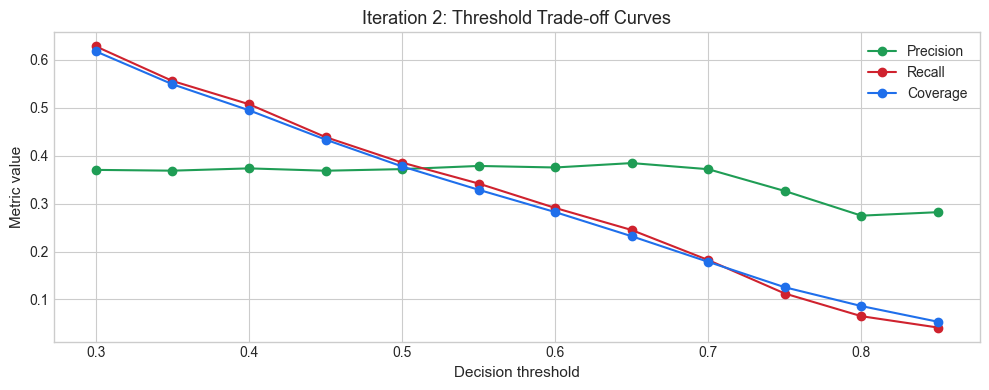

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(sweep['threshold'], sweep['precision'], marker='o', label='Precision', color=C_BUY)
ax.plot(sweep['threshold'], sweep['recall'], marker='o', label='Recall', color=C_RISK)
ax.plot(sweep['threshold'], sweep['coverage'], marker='o', label='Coverage', color=C_MAIN)
ax.set_title('Iteration 2: Threshold Trade-off Curves')
ax.set_xlabel('Decision threshold')
ax.set_ylabel('Metric value')
ax.legend()
plt.tight_layout()
plt.show()


In [23]:
# Strategy-level threshold evaluation (non-overlapping 5-day periods)
threshold_grid = np.arange(0.30, 0.86, 0.05)
t_eval = test_df.copy()
t_eval['proba'] = base_proba

rows = []
for th in threshold_grid:
    temp = t_eval.copy()
    temp['signal'] = (temp['proba'] >= th).astype(int)

    all_dates = sorted(temp['date'].unique())
    trade_dates = all_dates[::5]
    bt = temp[temp['date'].isin(trade_dates)].copy()
    bt['strategy_return'] = bt['signal'] * bt['future_return']

    period_ret = bt.groupby('date')['strategy_return'].mean()
    if len(period_ret) < 2:
        continue

    equity = (1 + period_ret).cumprod()

    rows.append({
        'threshold': th,
        'annualized_return': annualized_return(equity, periods_per_year=252/5),
        'sharpe': sharpe_ratio(period_ret, periods_per_year=252/5),
        'max_drawdown': max_drawdown(equity),
        'coverage': float((temp['signal'] == 1).mean()),
        'final_equity': float(equity.iloc[-1]),
    })

threshold_backtest = pd.DataFrame(rows).sort_values('sharpe', ascending=False)
threshold_backtest


,threshold,annualized_return,sharpe,max_drawdown,coverage,final_equity
0,0.30,0.312789,0.886144,-0.462336,0.617939,2.482665
1,0.35,0.263411,0.813788,-0.393303,0.549375,2.173348
2,0.40,0.234201,0.777527,-0.378345,0.495041,2.022495
3,0.45,0.130386,0.570951,-0.403476,0.433808,1.543592
4,0.50,0.034595,0.323192,-0.438912,0.377749,1.175613
6,0.60,0.013311,0.257022,-0.418119,0.282449,1.102808
5,0.55,0.011022,0.254126,-0.451268,0.329021,1.095166
7,0.65,-0.023864,0.129794,-0.416021,0.231997,0.983057
10,0.80,-0.003799,0.069333,-0.203405,0.086244,0.988364
8,0.70,-0.025113,0.034853,-0.415142,0.178525,0.924763


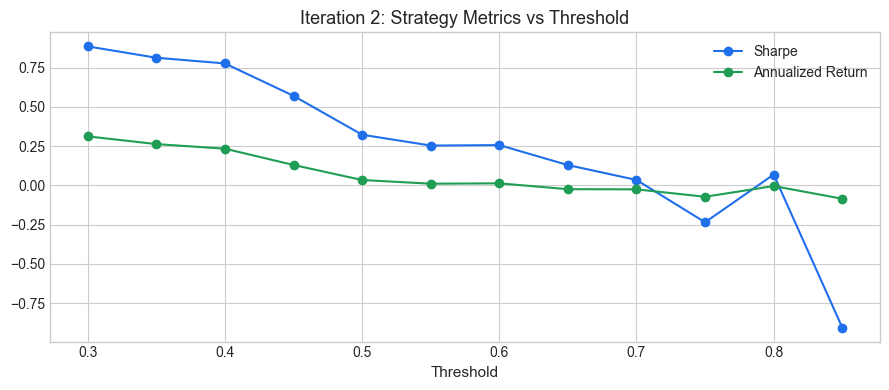

In [24]:
if not threshold_backtest.empty:
    p = threshold_backtest.sort_values('threshold')
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.plot(p['threshold'], p['sharpe'], marker='o', label='Sharpe', color=C_MAIN)
    ax.plot(p['threshold'], p['annualized_return'], marker='o', label='Annualized Return', color=C_BUY)
    ax.set_title('Iteration 2: Strategy Metrics vs Threshold')
    ax.set_xlabel('Threshold')
    ax.legend()
    plt.tight_layout()
    plt.show()


### 7.4 Feature Ablation (Iteration 3)
I drop feature groups one at a time to verify whether each block adds real predictive value.


In [25]:
ablation = run_xgboost_ablation(X_train, y_train_cmp, X_test, y_test_cmp, threshold=0.50, random_state=SEED)
ablation


,experiment,n_features,threshold,precision,recall,f1,coverage,roc_auc,pr_auc
0,drop_trend_momentum,12,0.5,0.394645,0.401183,0.397887,0.370418,0.521252,0.386700
1,drop_volatility_atr,36,0.5,0.375596,0.466272,0.416051,0.452350,0.502418,0.356103
2,drop_macro_rates,39,0.5,0.363810,0.226036,0.278832,0.226391,0.506535,0.377029
3,full_model,42,0.5,0.362998,0.366864,0.364921,0.368262,0.510225,0.363384
4,drop_sentiment,42,0.5,0.362998,0.366864,0.364921,0.368262,0.510225,0.363384


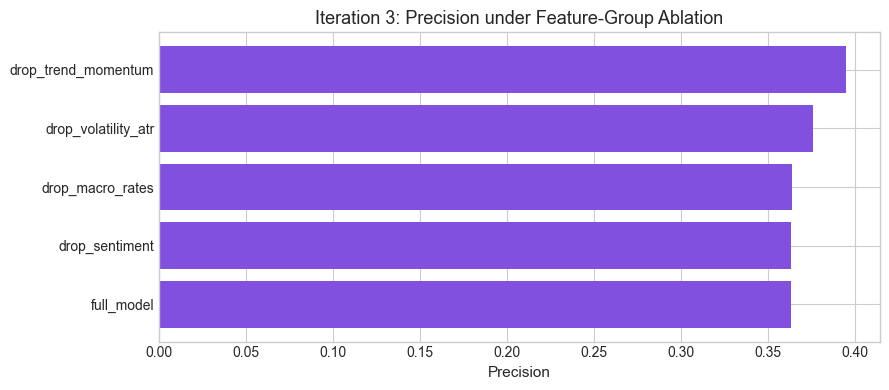

In [26]:
fig, ax = plt.subplots(figsize=(9, 4))
pp = ablation.sort_values('precision', ascending=True)
ax.barh(pp['experiment'], pp['precision'], color='#8250df')
ax.set_title('Iteration 3: Precision under Feature-Group Ablation')
ax.set_xlabel('Precision')
plt.tight_layout()
plt.show()


### 7.5 Challenges and Limitations Encountered
I explicitly track key challenges:
- Class imbalance lowers recall for high thresholds.
- Results vary by threshold, so I cannot report one metric in isolation.
- Optional sentiment coverage may be sparse and time-local.
- Backtest still excludes execution frictions.


## VIII. Results and Discussion

I synthesize results from baseline + three iterations into a final decision table.


In [27]:
# Build a compact decision summary
best_model_row = model_cmp.iloc[0].to_dict() if not model_cmp.empty else {}
best_threshold_row = threshold_backtest.iloc[0].to_dict() if not threshold_backtest.empty else {}
best_ablation_row = ablation.iloc[0].to_dict() if not ablation.empty else {}

decision_summary = pd.DataFrame([
    {
        'decision_area': 'best_model_at_0.50',
        'choice': best_model_row.get('model', None),
        'precision': best_model_row.get('precision', None),
        'recall': best_model_row.get('recall', None),
        'coverage': best_model_row.get('coverage', None),
    },
    {
        'decision_area': 'best_threshold_by_sharpe',
        'choice': best_threshold_row.get('threshold', None),
        'precision': None,
        'recall': None,
        'coverage': best_threshold_row.get('coverage', None),
    },
    {
        'decision_area': 'best_ablation_experiment',
        'choice': best_ablation_row.get('experiment', None),
        'precision': best_ablation_row.get('precision', None),
        'recall': best_ablation_row.get('recall', None),
        'coverage': best_ablation_row.get('coverage', None),
    },
])

decision_summary


,decision_area,choice,precision,recall,coverage
0,best_model_at_0.50,RandomForest,0.393526,0.273373,0.253126
1,best_threshold_by_sharpe,0.3,NaN,NaN,0.617939
2,best_ablation_experiment,drop_trend_momentum,0.394645,0.401183,0.370418


### Discussion: Strengths, Weaknesses, and Practical Implications

**Strengths**
- I maintain strict temporal validation.
- I test multiple model families before selecting one.
- I optimize threshold with both ML and trading metrics.
- I verify feature-group value through ablation.

**Weaknesses**
- Performance depends on threshold policy and market regime.
- Strategy test omits transaction costs and slippage.
- Confidence calibration is not yet applied.

**Practical Implications**
- The model is most useful as a **decision support layer** rather than a standalone trading engine.
- Threshold selection should match risk appetite and turnover constraints.
- ATR-aware features improve regime alignment for volatile names.


## IX. Conclusion

I achieved the capstone objective: I built and evaluated a reproducible, regime-aware ML pipeline that predicts 5-day upside events and supports data-driven trading decisions.

Key lessons:
- I gain more value from disciplined validation and iteration than from single-model optimization.
- Threshold policy can change practical performance more than small model tweaks.
- Feature relevance must be tested, not assumed.


## X. Future Work

1. Add transaction-cost and slippage modeling.  
2. Add probability calibration (Platt scaling / isotonic regression).  
3. Add walk-forward retraining and drift monitoring.  
4. Test regime-switching logic between stable and high-volatility universes.  
5. Add alternative data: options flow, earnings-event tags, intraday volatility.  
6. Add deployment-ready monitoring dashboards and alert thresholds.


## XII. Appendices

### Appendix A: Configuration and Setup Snapshot


In [28]:
import platform
import sklearn
import xgboost

config_snapshot = pd.Series({
    'seed': SEED,
    'window_days': 14,
    'horizon_days': 5,
    'target_threshold': 0.035,
    'train_test_cutoff': '2023-01-01',
    'python_version': platform.python_version(),
    'numpy_version': np.__version__,
    'pandas_version': pd.__version__,
    'scikit_learn_version': sklearn.__version__,
    'xgboost_version': xgboost.__version__,
})
config_snapshot


seed                            42
window_days                     14
horizon_days                     5
target_threshold             0.035
train_test_cutoff       2023-01-01
python_version             3.11.14
numpy_version                2.3.5
pandas_version               2.3.3
scikit_learn_version         1.8.0
xgboost_version              3.1.3
dtype: object

### Appendix B: Pseudocode

```text
LOAD raw price + macro data
VALIDATE quality constraints
ENGINEER technical + volatility features
BUILD rolling-window dataset and labels
SPLIT chronologically into train/test
TRAIN baseline + alternative models
EVALUATE ML metrics and strategy metrics
TUNE threshold for risk/return trade-off
RUN feature ablation for robustness
SUMMARIZE final decisions and limitations
```


In [29]:
# Optional: latest news context used by the broader project
if news.empty:
    print('No news_headlines.csv available.')
else:
    news.sort_values('date', ascending=False).head(15)
